# Laboratorio 2 - Informe

### Grupo 4:
     - S. Calvo C.I 5.711.417-7     
     - X. Iribarnegaray C.I 5.253.705-9
     - J. Simonelli C.I 5.405.358-4

## 1. Objetivos
El objetivo de este laboratorio es:
- Implementar el algoritmo Naive Bayes
- Aplicar herramientas de metodología
- Analizar los resultados obtenidos.

## 2. Diseño
### 2.1 Algoritmo

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, auc, precision_recall_curve, accuracy_score, precision_score, recall_score, f1_score
from matplotlib import pyplot as plt
from sklearn.base import ClassifierMixin, BaseEstimator
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import cross_validate
from IPython.display import display

DATASET_FILE = "./lab1_dataset.csv"
dataset = pd.read_csv(DATASET_FILE, sep=",")
target = 'cid'
continuous_features = [
    'time',
    'age', 
    'wtkg', 
    'preanti', 
    'cd40', 
    'cd420', 
    'cd80', 
    'cd820'
]
features = [
    'time', 
    'trt', 
    'age', 
    'wtkg', 
    'hemo', 
    'homo', 
    'drugs', 
    'karnof',
    'oprior', 
    'z30', 
    'zprior', 
    'preanti', 
    'race', 
    'gender', 
    'str2', 
    'strat',
    'symptom', 
    'treat', 
    'offtrt', 
    'cd40', 
    'cd420', 
    'cd80', 
    'cd820'
]
dataset = dataset.drop(['pidnum'], axis=1)
print(dataset[target].value_counts())

cid
0    1618
1     521
Name: count, dtype: int64


### Implementación de Naive-Bayes

In [2]:
def naive_bayes(dataset, target, features, instance, m):
    dataset_size = dataset.shape[0]
    prob_1 = dataset[target].value_counts()[1]/dataset_size
    prob_0 = dataset[target].value_counts()[0]/dataset_size
    
    product_1 = prob_1
    product_0 = prob_0
    
    for feature in features:
        examples = dataset.loc[dataset[feature] == instance[feature]][target].value_counts()
        
        # if no instances with a specific target value is found, the get method will return 0
        count_1 = examples.get(1, default=0)
        count_0 = examples.get(0, default=0)
        
        feature_range = len(dataset[feature].value_counts())
        
        numerator_1 = count_1 + (m / feature_range)
        numerator_0 = count_0 + (m / feature_range)

        # product of sequence
        product_1 *= ( numerator_1 / (dataset[target].value_counts()[1] + m) )
        product_0 *= ( numerator_0 / (dataset[target].value_counts()[0] + m) )
        
    return (product_0/(product_0 + product_1), product_1/(product_0 + product_1))

Naive-Bayes es un método de inferir las probabilidades de pertenencia de una instancia a una clase. Para lograr esto, se asumen independientes los atributos lo que facilitan el calculo. Para cada atributo, se estima la probabilidad condicional de que una instancia pertenezca a una clase específica, dado el valor del atributo. Dada la asuncion anterior, estas probabilidades se definen como:

$$P((a_1,a_2,...,a_n) | H) = P(a_1|H)\cdot ... \cdot P(a_n|H)$$

A continuación, se detalla nuestra implementación de este algoritmo.

Nuestra implementación del algoritmo recibe cinco parámetros. En orden se recibe el conjunto de datos (dataset), la columna objetivo (target), los atributos (features), la instancia que se desea predecir (instance), y el hiperparámetro m.

Se comienza calculando las probabilidades previas para las clases 0 y 1. Posteriormente, para cada atributo, se estima la probabilidad condicional de que se pertenezca a cada clase objetivo según el valor del atributo en la instancia a predecir. En este cálculo se utiliza el m-estimador para no dar probabilidad 0 a valores que no se observaron, aumentando el tamaño de la muestra con más ejemplos distribuidos según la probabilidad previa de tener este valor.
$$\text{m-estimador}: \frac{e + m\cdot p}{n+m}$$
Donde e son los ejemplos, m el hiperparametro, p la probabilidad previa de tener el valor y n el tamaño del conjunto de datos.

Finalmente, utilizando el producto de las probabilidades condicionales acumuladas, se obtiene la probabilidad total de que la instancia pertenezca a la clase 0 o 1. Es importante notar que nuestra implementación no realiza la clasificación final, sino que devuelve un par de probabilidades. La primera representa la probabilidad de que la instancia pertenezca a la clase 0 y la segunda que pertenezca a la clase 1.

### Implementación de Naive-Bayes logarítmico

In [3]:
def naive_bayes_log(dataset, target, features, instance, m):
    dataset_size = dataset.shape[0]
    prob_1 = dataset[target].value_counts()[1]/dataset_size
    prob_0 = dataset[target].value_counts()[0]/dataset_size
    
    sum_1 = np.log(prob_1)
    sum_0 = np.log(prob_0)
    
    for feature in features:
        examples = dataset.loc[dataset[feature] == instance[feature]][target].value_counts()
        
        # if no instances with a specific target value is found, the get method will return 0
        count_1 = examples.get(1, default=0)
        count_0 = examples.get(0, default=0)
        
        feature_range = len(dataset[feature].value_counts())
        
        numerator_1 = count_1 + (m / feature_range)
        numerator_0 = count_0 + (m / feature_range)

        # sum of sequence
        sum_1 += np.log( numerator_1 / (dataset[target].value_counts()[1] + m) )
        sum_0 += np.log( numerator_0 / (dataset[target].value_counts()[0] + m) )
        
    return (np.exp(sum_0)/(np.exp(sum_0) + np.exp(sum_1)), np.exp(sum_1)/(np.exp(sum_0) + np.exp(sum_1)))

In [4]:
class CustomNaiveBayes(BaseEstimator, ClassifierMixin):
    def __init__(self, features, m):
        self.features = features
        self.m = m

    def fit(self, X_train, y_train):
        self.classes_ = np.unique(y_train)
        self.X_train = X_train.copy()
        self.y_train = y_train.copy()
        self.X_train[target] = y_train
        return self

    def predict(self, X_test):
        y_pred = []
        for i in range(0, X_test.shape[0]):
            instance = X_test.iloc[i]
            prob_0, prob_1 = naive_bayes(self.X_train, target, self.features, instance, self.m)
            if (prob_0 > prob_1):
                y_pred.append(0)
            else:
                y_pred.append(1)
        return np.array(y_pred)
    
    
    def __sklearn_clone__(self):
        return self

Además de la implementación de naive-Bayes mediante probabilidades, se implementó la variación de naive-Bayes logarítmico. En esta variante, en vez de trabajar con las probabilidades, se utilizan sus logaritmos, lo que amplía el rango de valores, reduce el riesgo de inestabilidades numéricas y convierte productos en sumas. Debido a esta última propiedad, el cálculo del producto de las probabilidades condicionales se intercambia por la sumatoria de probabilidades logarítmicas. Para el resultado devuelto se deshace la conversión logarítmica con el propósito de obtener las probabilidades. Aun así, los logaritmos preservan el orden relativo entre los valores (a < b si y sólo si ln(a) < ln(b)).

Con el propósito de utilizar la función de validación cruzada de sk-learn, se creó una clase `CustomNaiveBayes`. Esta función `cross_validate` requiere de un objeto que represente al estimador e implemente una función llamada `fit` así como la función `predict`. En este caso la función `fit` define el conjunto de datos a usar y `predict` realiza la predicción de un conjunto de instancias. 


### 2.3 Evaluación

En el contexto de la evaluación de modelos de clasificación, se utilizan varias métricas para medir el rendimiento de un clasificador. En los experimentos que realizaremos a continucaión en el informe, utilizaremos las métricas de acierto (accuracy), precisión (precision), recuperación (recall) y medida f1 (f1 score) en su forma ponderada (average=weighted) debido a la naturaleza desbalanceada del dataset: 76% de las instancias pertenecen a la clase 0 y 24% a la clase 1.

#### Accuracy

La accuracy es la proporción de instancias correctamente clasificadas sobre el total de instancias en el conjunto de datos.

$$
\text{Accuracy} = \frac{TP + TN}{Total}
$$

donde $TP$ son verdaderos positivos, $TN$ verdaderos negativos, y $Total$ la cantidad total de instancias.

Esta métrica ofrece una visión global del rendimiento del modelo, pero en datasets desbalanceados, como en este caso, donde domina la clase 0, puede ser engañosa, ya que el modelo puede obtener una alta accuracy simplemente clasificando la clase mayoritaria correctamente, sin clasificar adecuadamente la clase minoritaria.

#### Precision

La precision mide la proporción de instancias correctamente clasificadas como positivas entre todas las clasificadas como positivas por el modelo.

$$
\text{Precision} = \frac{TP}{TP + FP}
$$

La precision es útil cuando el costo de los falsos positivos es elevado, es decir, cuando es importante evitar clasificar incorrectamente una instancia negativa como positiva.

#### Recall

El recall mide la capacidad del modelo para identificar correctamente todas las instancias de la clase positiva.

$$
\text{Recall} = \frac{TP}{TP + FN}
$$

Este valor indica cuántos de los ejemplos positivos fueron correctamente detectados por el modelo. Es útil cuando el objetivo es minimizar los falsos negativos.

#### F1 Score

El f1 score es la media armónica entre precision y recall.

$$
F1 = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
$$
​
Esta métrica es útil cuando se busca un equilibrio entre precision y recall, especialmente en datasets desbalanceados, donde la accuracy no refleja de manera adecuada el rendimiento del modelo.

#### Average = weighted

En datasets desbalanceados, las clases mayoritarias pueden dominar las métricas si se utilizan versiones simples (no ponderadas) de estas. Para evitar que esto ocurra, utilizamos el parámetro average=weighted, el cual pondera las métricas de cada clase en función de el número de instancias pertenecientes a esa clase en el dataset.

La versión ponderada, para cualquier métrica $M$ (precision, recall o f1 score), en un dataset con 2 clases, se calcula como:

$$M_{\text{weighted}} = \frac{M_0 \cdot s_0 + M_1 \cdot s_1}{s_0 + s_1}$$

Donde:
- $M_0$ y $M_1$ son las métricas para la clase negativa (0) y la clase positiva (1), respectivamente.
- $s_0$ y $s_1$ son el número de muestras de la clase negativa y la clase positiva, respectivamente.

Esto asegura que el rendimiento del modelo se evalúe de manera justa en relación con la distribución de las clases.



## 3. Experimentación

### 3.1 Evaluación del hiperparametro m

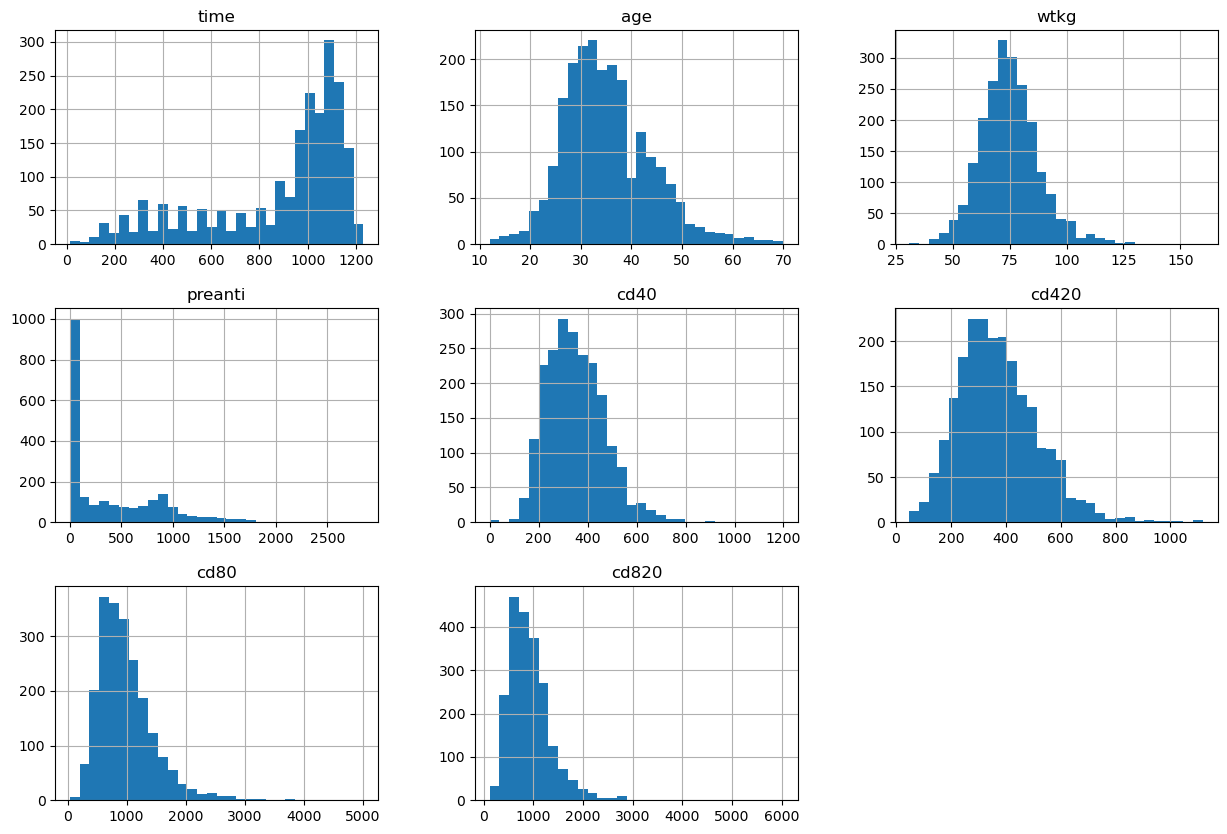

In [5]:
dataset[continuous_features].hist(bins=30, figsize=(15, 10))
plt.show()

#### Preprocesamiento de datos

Dado que nuestra implementación de Naive Bayes no soporta atributos continuos, utilizamos KBinsDiscretizer para convertir los atributos continuos en atributos categóricos. KBinsDiscretizer recibe como parámetros n_bins: el número de rangos a dividir, encode: el método de codificación de las categorías, y strategy: la estrategia para elegir los rangos a dividir. La estrategia puede ser:

- **uniform**: divide el rango de los valores en intervalos de igual tamaño.
- **quantile**: divide los valores en intervalos de tal manera que cada uno contenga aproximadamente la misma cantidad de datos.
- **kmeans**: utiliza el algoritmo de clustering kmeans para agrupar los datos en bins basados en patrones naturales de los mismos.

Las gráficas muestran que los atributos continuos presentan distribuciones con concentraciones de valores en ciertos rangos, por lo que consideramos la estrategia **kmeans** como la más adecuada para discretizar, ya que permite capturar de forma más precisa estas agrupaciones naturales.

In [6]:

# Initialize KBinsDiscretizer for continuous features
kbins = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='kmeans')

# Discretize continuous features
dataset[continuous_features] = kbins.fit_transform(dataset[continuous_features])

# Prepare X and y
X = dataset.drop(target, axis=1)
y = dataset[target]

# List of m values
m_values = [1, 10, 100, 1000]

results = pd.DataFrame(columns=['m', 'Accuracy', 'Precision', 'Recall', 'F1'])

# Iterate over m values
for m in m_values:
    model = CustomNaiveBayes(features, m)
    scores = cross_validate(model, X, y, cv=5, scoring=['accuracy', 'precision_weighted', 'recall_weighted','f1_weighted'] )
    results.loc[results.shape[0]] = [m, scores['test_accuracy'].mean(), scores['test_precision_weighted'].mean(), scores['test_recall_weighted'].mean(), scores['test_f1_weighted'].mean()]

def bold_max(s):
    is_max = s == s.max()
    return ['font-weight: bold' if v else '' for v in is_max]

styled_results = results.style.apply(bold_max, subset=['F1'])

display(styled_results)



,m,Accuracy,Precision,Recall,F1
0,1.000000,0.851315,0.848938,0.851315,0.849666
1,10.000000,0.852252,0.850432,0.852252,0.851069
2,100.000000,0.841971,0.836428,0.841971,0.836854
3,1000.000000,0.769518,0.782551,0.769518,0.686887


En el experimento, evaluamos el rendimiento de nuestra implementación de Naive Bayes al variar el parámetro de suavización $m$ entre los valores 1, 10, 100 y 1000. Para medir la efectividad del modelo para cada valor de $m$, utilizamos cross-validation dividiendo el dataset en 5 particiones. En cada iteración, el modelo fue entrenado en 4 particiones y evaluado en la partición restante, repitiendo este proceso hasta haber evaluado en todas las particiones. Luego, tomamos el promedio entre las iteraciones para cada métrica como resultado.

En lugar de implementar manualmente este proceso, utilizamos la función cross_validate de scikit-learn, que automatiza el procedimiento y facilita el cálculo de las métricas de rendimiento para cada valor de $m$.

#### Resultados
- Para $m=1$, la accuracy, precision, recall y f1 score están alrededor de 0.85, lo que indica un buen rendimiento inicial.
- Con $m=10$, todas las métricas mejoran ligeramente, con una accuracy de 0.852 y un f1 score de 0.851, lo que lo convierte en el mejor valor de suavización.
- Para $m=100$, el rendimiento disminuye, con una accuracy de 0.842 y métricas ligeramente más bajas, lo que sugiere que este valor no es ideal.
- Finalmente, con $m=1000$, el rendimiento cae drásticamente, con una accuracy de 0.770 y un f1 score de 0.687, lo que indica un ajuste excesivo de la suavización.

$m=10$ ofrece el mejor rendimiento en todas las métricas evaluadas.



### 3.2 Evaluación de feature selection

,k,Accuracy,Precision,Recall,F1
0,1.000000,0.836449,0.839559,0.836449,0.837819
1,2.000000,0.827103,0.821334,0.827103,0.823152
2,3.000000,0.831776,0.828269,0.831776,0.829679
3,4.000000,0.848131,0.844169,0.848131,0.845467
4,5.000000,0.841121,0.836068,0.841121,0.837491
5,6.000000,0.848131,0.843227,0.848131,0.844383
6,7.000000,0.841121,0.834661,0.841121,0.835047
7,8.000000,0.848131,0.842582,0.848131,0.843233
8,9.000000,0.862150,0.857795,0.862150,0.858234
9,10.000000,0.850467,0.845514,0.850467,0.846501


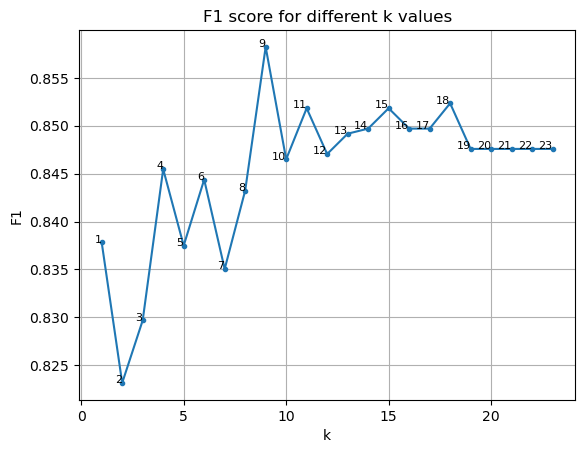

In [7]:
results = pd.DataFrame(columns=['k', 'Accuracy', 'Precision', 'Recall', 'F1'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
f1_array = []
k_array = list(range(1, 24))
for k in range(1,24):
    selector = SelectKBest(chi2, k=k)
    X_train_selected = selector.fit_transform(X_train, y_train)
    selected_features = X_train.columns[selector.get_support()]
    
    train_ds = X_train[selected_features].copy()
    train_ds[target] = y_train
    
    y_pred = []
    
    for i in range(0, X_test.shape[0]):
        instance = X_test.iloc[i]
        prob_0, prob_1 = naive_bayes(train_ds, target, selected_features, instance, 10)
        if (prob_0 > prob_1):
            y_pred.append(0)
        else:
            y_pred.append(1)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    f1_array.append(f1)
    
    results.loc[results.shape[0]] = [k, accuracy, precision, recall, f1]

styled_results = results.style.apply(bold_max, subset=['F1'])

display(styled_results)

plt.plot(k_array, f1_array, marker='.')
plt.title('F1 score for different k values')
plt.xlabel('k')
plt.ylabel('F1')
plt.grid()
for i, f1_value in enumerate(f1_array):
    plt.text(k_array[i], f1_array[i], f'{k_array[i]}', fontsize=8, ha='right')

plt.show()

En este experimento tenemos como objetivo realizar un análisis de selección de atributos utilizando el algoritmo Naive Bayes con el hiperparámetro de suavizado *m* fijo en 10, que por el experimento anterior es el *m* con mejor F1 score. Empleamos la técnica de selección de atributos `SelectKBest` junto con la estrategia **Chi-Square** (chi2) para seleccionar los mejores atributos, y para cada posible *k* (cantidad de mejores atributos del rango 1 a 23) evaluamos las métricas de rendimiento.

Respecto a la técnica de selcción de atributos usada, Chi-Square (chi2) se utiliza para evaluar la independencia de los atributos con respecto a la variable objetivo. Es particularmente efectiva cuando los atributos son categóricos, como en este caso después de la discretización de los atributos continuos mediante `KBinsDiscretizer`.

Hemos obtenido que con el valor de **k=9** se obtiene la mejor Medida F1 de **0.858234**. Este resultado sugiere que, utilizando nueve atributos, el modelo alcanzó un balance adecuado entre precisión y recall. Además, es posible observar que la Medida F1 no crece directamente con la cantidad de atributos evaluados, sino que por lo visto fluctúa. Esto nos indica que la adición de atributos no necesariamente mejora la calidad del modelo.

Comparando estos resultados con el modelo sin selección de atributos para **m=10**, el cual obtuvo un F1 de **0.851069**, observamos que la mejora en el F1 score utilizando selección de atributos con **k=9** (F1 = 0.858234) es marginal. Esto sugiere que la selección de atributos ayuda a mejorar el rendimiento, pero no de manera significativa en este caso. La diferencia es pequeña, lo que indica que el modelo completo, sin reducción de atributos, ya está capturando la mayoría de la información relevante. Sin embargo, utilizar una selección de atributos más pequeña podría seguir siendo beneficioso en términos de eficiencia, ya que el algoritmo de Naive Bayes estaría efectuando menos cálculos para clasificar una instancia (menos productos o adiciones dependiendo de la implementación). Además, se logra simplificar el modelo y mejorar de la interpretabilidad al reducir la cantidad de variables y potencialmente eliminar redundancias.

In [8]:
selector = SelectKBest(chi2, k='all')
X_train_selected = selector.fit_transform(X_train, y_train)
selected_features = X_train.columns[selector.get_support()]

train_ds = X_train[selected_features].copy()
train_ds[target] = y_train

chi2_scores = selector.scores_

feature_scores = pd.DataFrame({
    'Feature': selected_features,
    'Chi2_Score': chi2_scores,
})

feature_scores_sorted = feature_scores.sort_values(by='Chi2_Score', ascending=False)
styled_results = feature_scores_sorted.style.apply(bold_max, subset=['Chi2_Score'])

display(styled_results)


,Feature,Chi2_Score
0,time,487.569962
20,cd420,211.352491
19,cd40,55.228008
11,preanti,47.215085
16,symptom,21.059162
1,trt,13.135860
21,cd80,10.376097
15,strat,9.025053
9,z30,8.650495
17,treat,8.618287


Una vez obtenidos los resultados del experimento anterior, realizamos un análisis más detallado de la importancia de cada uno de los atributos utilizando la técnica de Chi-Square para identificar cuáles de ellos tienen mayor relevancia para la predicción de la variable objetivo.\
De acuerdo con las puntuaciones obtenidas, los resultados muestran que el atributo time es el más relevante con un valor Chi2 de 487.56, seguido por cd420 (211.35) y preanti (55.22). Esto indica que estos atributos tienen una mayor influencia en la predicción de la clase objetivo. En el extremo opuesto, atributos como homo y zprior muestran puntuaciones muy bajas, lo que sugiere que tienen poca o ninguna relevancia para la predicción.

### 3.3 Curva de Precision-Recall

<Figure size 640x480 with 0 Axes>

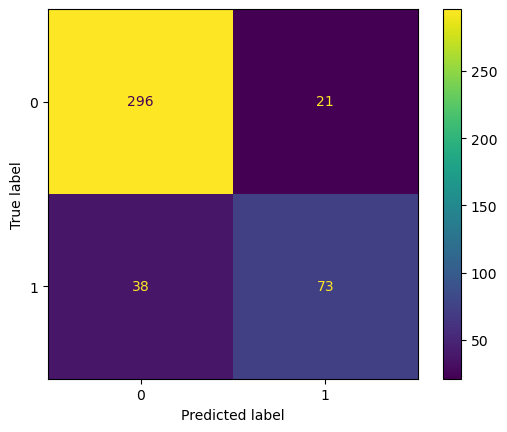

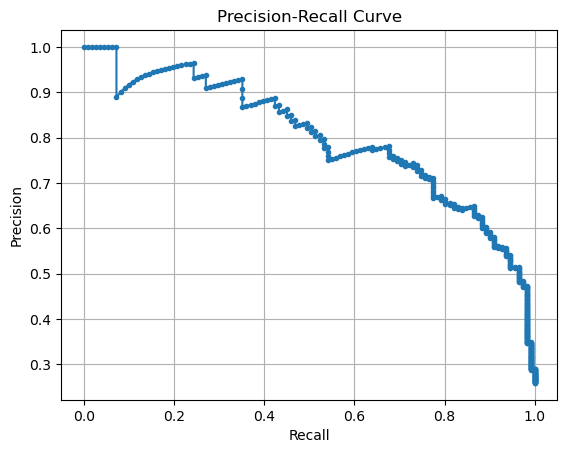

Area Under Curve: 0.7995841669429639



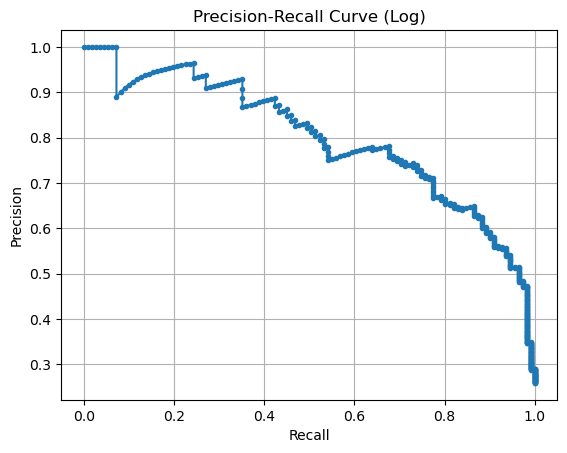

Area Under Curve (Log): 0.799584166942964



In [9]:
selector = SelectKBest(chi2, k=9)
X_train_selected = selector.fit_transform(X_train, y_train)
selected_features = X_train.columns[selector.get_support()]

train_ds = X_train[selected_features].copy()
train_ds[target] = y_train

y_score = []
y_score_log = []
y_pred = []

for i in range(0, X_test.shape[0]):
    instance = X_test.iloc[i]
    prob_0, prob_1 = naive_bayes(train_ds, target, selected_features, instance, 10)
    prob_log_0, prob_log_1 = naive_bayes_log(train_ds, target, selected_features, instance, 10)
    y_score.append(prob_1)
    y_score_log.append(prob_log_1)
    if (prob_0 > prob_1):
        y_pred.append(0)
    else:
        y_pred.append(1)
        
precision, recall, thresholds = precision_recall_curve(y_true=y_test, y_score=y_score)
precision_log, recall_log, thresholds_log = precision_recall_curve(y_true=y_test, y_score=y_score_log)

area_under_curve = auc(recall, precision)
area_under_curve_log = auc(recall_log, precision_log)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
plt.figure() 
disp.plot()
plt.show() 

# Precision-Recall Curve
plt.figure() 
plt.plot(recall, precision, marker='.')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.show() 
print(f"Area Under Curve: {area_under_curve}\n")

# Precision-Recall Curve (Log Scale)
plt.figure() 
plt.plot(recall_log, precision_log, marker='.')
plt.title('Precision-Recall Curve (Log)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.show()
print(f"Area Under Curve (Log): {area_under_curve_log}\n")


En este experimento, seleccionamos el mejor valor de **k** obtenido en los resultados anteriores, el cual es **k=9**. A partir de esto, seleccionamos los 9 atributos más relevantes utilizando la técnica de selección de atributos basada en Chi-Square y calculamos tanto la curva de precision-recall como el área bajo la curva (AUC) para ambas implementaciones del algoritmo Naive Bayes: una versión tradicional basada en el producto de probabilidades, y una versión que utiliza las probabilidades en forma logarítmica. También calculamos la matriz de confusión para evaluar mejor el desempeño del modelo.

Para la implementación tradicional de Naive Bayes (`naive_bayes`), calculamos las probabilidades a través del producto acumulativo de las probabilidades de cada atributo dado un valor de la clase objetivo. Esto funciona bien para conjuntos de datos reducidos o con pocos atributos, pero cuando el número de atributos es mayor, el producto de muchos valores pequeños puede llevar a problemas de desbordamiento numérico, ya que las probabilidades se hacen extremadamente pequeñas. En nuestro caso, con **k=9** no observamos problemas numéricos significativos debido al tamaño relativamente pequeño del conjunto de atributos.

En la implementación logarítmica (`naive_bayes_log`), las probabilidades se manejan sumando los logaritmos de las probabilidades individuales, en lugar de multiplicarlas directamente. Esta técnica es conocida por su estabilidad numérica, ya que evita los problemas de desbordamiento asociados con la multiplicación de números pequeños. Sin embargo, al final del proceso, es necesario normalizar y transformar las probabilidades logarítmicas de vuelta a su forma exponencial para obtener probabilidades que se puedan comparar directamente.

Al calcular la curva de precisión-recall para ambas versiones, observamos que los resultados obtenidos son idénticos, como se muestra en las figuras anteriores. Ambas curvas tienen un área de aproximadamente **0.7996**, lo que indica que, desde el punto de vista de pérdida de datos, no es necesario utilizar la implementación logarítmica sobre la tradicional.

La matriz de confusión nos muestra que la implementación logró predecir correctamente 296 de las instancias de la clase negativa y 73 de las instancias de la clase positiva, con 21 falsos positivos y 38 falsos negativos. Esto sugiere que, aunque el modelo es bastante preciso prediciendo la clase negativa, tiene más dificultad para identificar correctamente las instancias de la clase positiva. Esta tendencia también se refleja en la curva de precision-recall, donde la precisión es alta para valores bajos de recall, pero disminuye a medida que el recall aumenta.


### Comparar con lab anterior